In [225]:
import os, time
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.optimize import fmin

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc, rcParams
from linfitODR import linfit
%matplotlib inline


#switch off warnings
import warnings
warnings.filterwarnings("ignore")
#Style stuff:

rcParams.update({'errorbar.capsize': 0})
rc('text', usetex=True)
rc('font', size=11)
rc('legend', fontsize=11)
rcParams.update({'font.size':11})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

linestylesdict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

def betafixed(b,xi,yi):
    zw = ((b-xi-yi)**2).sum()
    return np.sqrt(zw)

def linestyles(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:linestyles['densely dashed'], 
             3250:linestyles['densely dotted'],
             3500:linestyles['densely dashdotted'],
             3750:linestyles['densely dashdotdotted']}
        return c[Tmin]
    else: 
        return '-'

def markers(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:'o', 
             3250:'x',
             3500:'^',
             3750:'D'}
        return c[Tmin]
    else: 
        return '-'


def colorize(age):
    if age==0.125:
        return 'k'
    elif age == 0.63:
        return 'r'

def multicolorize(age):
    c = []
    for a in age:
        if a==0.125:
            c.append('k')
        elif a == 0.63:
            c.append('r')
    print(c)
    return c

def load(usecols=None):
    trange = {'M44': [
                       (3e3,7e3,'o', 5e28, 5e36, 0.630),   
                       (3e3,3.249e3,'o', 5e28, 5e36, 0.630),
                       (3.25e3,3.499e3,'o', 5e28, 5e36, 0.630),
                       (3.5e3,3.749e3,'o', 5e28, 5e36, 0.630),
                       (3.75e3,4e3,'o', 5e28, 5e36, 0.630),
                     ],
              'M44 - no binaries': [
                       (3e3,7e3,'s', 5e28, 5e36, 0.630),   
                       (3e3,3.249e3,'s', 5e28, 5e36, 0.630),
                       (3.25e3,3.499e3,'s', 5e28, 5e36, 0.630),
                       (3.5e3,3.749e3,'s', 5e28, 5e36, 0.630),
                       (3.75e3,4e3,'s', 5e28, 5e36, 0.630),
                     ],


         'Pleiades': [
                      (3e3,7e3,'v', 5e28, 5e36, 0.125),
                      (3e3,3.249e3,'v', 5e28, 5e36, 0.125),
                      (3.25e3,3.499e3,'v', 5e28, 5e36, 0.125),
                      (3.5e3,3.749e3,'v', 5e28, 5e36, 0.125),
                      (3.75e3,4e3,'v', 5e28, 5e36, 0.125),
                      ],}

    df = pd.DataFrame()
    for key in trange.keys():
         for (Tmin,Tmax,color,emin,emax,age) in trange[key]:
            if key == 'M44 - no binaries':
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD_nobin.csv'.format(loc,test,key[:3],Tmin,Tmax),
                                  usecols = usecols)
                df2['nobin'] = True
                df2['clr'] = color
            else:
                df2 = pd.read_csv('{}{}_{}_{}_{}_FFD.csv'.format(loc,test,key,Tmin,Tmax),
                                                                usecols = usecols)
                df2['nobin'] = False
                df2['clr'] = color

            df2['age'] = age
            df = df.append(df2)
    return df
    
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c'),(3000.0,7000.0,'k'),]


In [126]:
#merge detection thresholds
run = '05'
threshs = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_{}_median_detection_thresholds.csv'.format(run))
#threshs = pd.read_csv('stars_shortlist/share/run_{}_median_detection_thresholds.csv'.format(run))

value_vars = ['Pleiades','M44','M67']
id_vars = ['Tmin','Tmax']
t = pd.melt(threshs, value_vars=value_vars, var_name='cluster',
            value_name='threshold', id_vars=id_vars)
t = t[t.cluster !='M67']
t.to_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_{}_median_detection_thresholds_melted.csv'.format(run))
t

,Tmin,Tmax,cluster,threshold
0,3000,3249,Pleiades,1.234378e+32
1,3250,3499,Pleiades,1.726234e+32
2,3500,3749,Pleiades,1.845931e+32
3,3750,4000,Pleiades,2.435808e+32
4,3000,7000,Pleiades,1.768141e+32
5,4000,7000,Pleiades,4.378624e+32
6,3000,3249,M44,3.426318e+32
7,3250,3499,M44,1.777936e+32
8,3500,3749,M44,1.123365e+32
9,3750,4000,M44,1.052825e+32


In [226]:
usecols= ['Tmax','Tmin','alpha','alpha_err','beta','beta_err','maxenerg','n_obj','nflares','cluster',]

res=load(usecols=usecols).drop_duplicates()
df = load()
res['alpha']= -res.alpha
res['beta2'] = np.nan
res['beta2_high_err'] = np.nan
res['beta2_low_err'] = np.nan
for Tmax, f in df.groupby('Tmax'):
    for cluster, g in f.groupby('cluster'):

        arrbeta = []
        for i in range(g.shape[0]):
            xi = np.delete(g['logE'].values,i)
            yi = np.delete(g['count_per_yr'].values, i)
            arrbeta.append(fmin(betafixed,x0=30,args=(xi,yi),disp=0)[0])
        std = np.asarray(arrbeta).std()
        mean = np.asarray(arrbeta).mean()    
        res.beta2[(res.Tmax == Tmax) & (res.cluster == cluster)] = mean
        res.beta2_high_err[(res.Tmax == Tmax) & (res.cluster == cluster)] = np.sqrt(std**2 + g.high_yerr.median()**2)
        res.beta2_low_err[(res.Tmax == Tmax) & (res.cluster == cluster)] = np.sqrt(std**2 + g.low_yerr.median()**2)
        
res

,Tmax,Tmin,alpha,alpha_err,beta,beta_err,cluster,maxenerg,n_obj,nflares,nobin,clr,age,beta2,beta2_high_err,beta2_low_err
0,7000,3000,2.164310,0.010238,38.246376,0.333300,Pleiades,1.800900e+34,712,496,False,v,0.125,32.875467,0.058166,0.067179
0,3249,3000,2.264119,0.014129,41.260270,0.457426,Pleiades,1.800900e+34,425,290,False,v,0.125,32.679741,0.082741,0.102305
0,3499,3250,2.300729,0.035912,42.938003,1.168353,Pleiades,4.153490e+33,77,96,False,v,0.125,33.117737,0.127418,0.181085
0,3749,3500,2.470531,0.046356,48.452337,1.506868,Pleiades,3.108667e+33,78,102,False,v,0.125,33.104511,0.111968,0.151247
0,4000,3750,2.048485,0.064505,34.864942,2.116383,Pleiades,1.205915e+34,37,34,False,v,0.125,33.260384,0.138766,0.205103
0,7000,3000,2.329990,0.023358,42.985339,0.760069,M44,5.070511e+33,732,119,False,o,0.630,32.202174,0.139088,0.205852
0,3249,3000,2.175726,0.057167,37.963804,1.868848,M44,5.070511e+33,327,27,False,o,0.630,32.195363,0.255239,0.698635
0,3499,3250,2.242364,0.025116,40.568179,0.816101,M44,3.497533e+33,95,46,False,o,0.630,32.623177,0.208995,0.418146
0,3749,3500,2.513495,0.112484,48.843407,3.631003,M44,8.315664e+32,110,30,False,o,0.630,32.163097,0.182339,0.320286
0,4000,3750,2.746051,0.237628,56.096153,7.668693,M44,3.915400e+32,48,7,False,o,0.630,31.959204,0.334150,2.778178


(1430, 18)


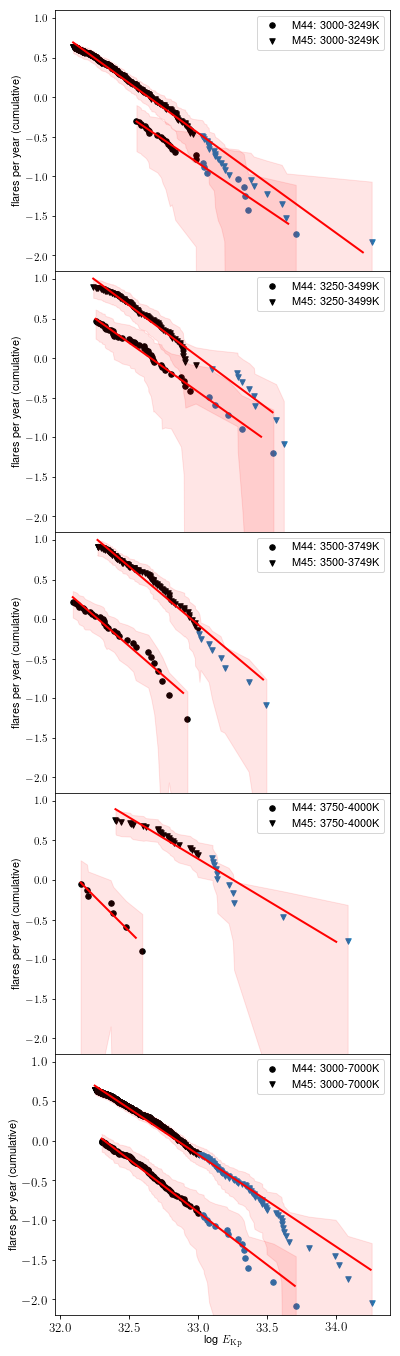

In [231]:
df = load()
print(df.shape)    
df = df.sort_values('Tmax')
fig, ax = plt.subplots(ncols=1, nrows=5,figsize=(6,24), sharex=True)
i=0
for name, g in df.groupby('Tmax'):
    for cluster, f in g.groupby('cluster'):
        
        for binary, h in f.groupby('nobin'):
            cond = (res.cluster==cluster) & (res.Tmax ==name) & (res.nobin==binary)
            if cluster == 'Pleiades':
                cluster = 'M45'
            if binary == True:
                continue
            h = h.sort_values(by='logE')
            h1 = h[h.logE<33]
            h2 = h[h.logE>33]
            h1.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],
                    label='{}: {}-{}K'.format(cluster,int(f.Tmin.values[0]),int(name)),
                    marker=h.clr[0],color='k',s=30)
            if h2.shape[0] > 0:
                h2.plot(x='logE', y='count_per_yr',kind='scatter',ax=ax[i],marker=h.clr[0],s=30)
            ax[i].fill_between(h.logE, h.count_per_yr-h.low_yerr, h.count_per_yr+h.high_yerr,
                             alpha=0.1,color='r')
            x = np.arange(h.logE.min(),h.logE.max(),0.1)
           
            ax[i].plot(x, -1.*(res.alpha[cond]-1.).values*x+res.beta[cond].values,
                      color='r',linewidth=2)
            ax[i].set_ylim(-2.2,1.1)
            ax[i].set_ylabel(r'flares per year (cumulative)')
            
 
    ax[i].set_xlabel(r'log $E_\mathrm{Kp}$')
    i+=1
    
    

plt.tick_params(axis = 'both', labelsize = 13)

#plt.tight_layout()
plt.subplots_adjust(hspace=0)

In [127]:


dats = []
for Tmin, Tmax, color in Tlims:
    locs2 = [#('M67','clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.3),
             ('M45','stars_shortlist/share/{}_Pleiades_{}_{}_energs.csv'.format(test,Tmin,Tmax),0.125),
             ('M44','stars_shortlist/share/{}_M44_{}_{}_energs.csv'.format(test,Tmin,Tmax),0.63),
             #('M44 - no binaries','stars_shortlist/share/{}_M44_{}_{}_energs_nobin.csv'.format(test,Tmin,Tmax),0.63),
    ]
             
    for (name, value, age) in locs2:
        try:
            df = pd.read_csv(value,
                         usecols = ['clustered','clusterederr','clusterenergy',
                                    'clusterenergy_err','Teff',
                                    'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',#'rel_energ_err'
                                    'count_true','energ_true'],
                         )
            df['cluster'] = name
            
        except (FileNotFoundError, OSError):
            print('Nothing in {}-{} for {}'.format(Tmin,Tmax,name))
            continue
        #select color bin:
        print(df.shape)
        df = df[(df.Tmin == Tmin) & (df.Tmax == Tmax)]
        df = df[df.count_true < 5.]
        
        
        df = df.dropna(how='any')
        if df.shape[0] == 0:
            print('No high probability events.')
            t.threshold[name]=np.nan 
            #do not count threshold if nothing is detected because no relevance for interpretation
            continue
        detthr = t[(t.Tmin==Tmin) & (t.Tmax==Tmax)].threshold.max()
        #detthr = 3.426318e32 #for alpha/FA/FR comparison, highest threshold available
        df = df[df.energ_true > detthr]
        #if (df.stars_in_bin != df.stars_in_bin.iloc[0]).any(): 
         #   raise ValueError('The number of stars in your bin is ambiguous.')
        #normalization constant
        if df.shape[0] == 0:
            print('No high energy events.')
            continue
        n_stars = df.stars_in_bin.iloc[0]
        FAerr = np.sqrt( df.clusterenergy_err**2 + ( df.energ_true * df.L_bol_err /  df.L_bol )**2 ) /  df.L_bol
        dats.append([ age, n_stars, detthr,
                    np.sqrt((df.clusterenergy_err**2).sum())/n_stars,
                    df.energ_true.sum()/n_stars, 
                    df.shape[0]/n_stars,
                    df.shape[0],
                    Tmin,Tmax,
                    (df.energ_true/df.L_bol).sum()/n_stars,
                     np.sqrt((FAerr**2).sum())/n_stars,])
dats = np.asarray(dats) 
data = pd.DataFrame(dats, columns=['age','n_stars','threshold',
                                   'tot_en_err','tot_en',
                                   'tot_flares_p_star','tot_flares',
                                   'Tmin','Tmax','FA','FA_err'])
for col in data.columns.values:
    if col!= 'cluster':
        data[col] = data[col].astype('float')
dur = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/dur.csv')
print(dur)
data = data.merge(dur, how='left', on=['Tmin','Tmax','age'])
data['dursec'] = data.dur*365*24*60*60
data['FA'] = data.FA/data.dursec
data['FA_err'] = data.FA_err/data.dursec
data['tot_flares_p_yr'] = data.tot_flares/data.dur
data['tot_flares_p_yr_err'] = np.sqrt(data.tot_flares)/data.dur
data.sort_values(by='age')




#data.to_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/all_FAFR.csv')

(290, 13)
(27, 13)
(96, 13)
(46, 13)
(102, 13)
(30, 13)
(34, 13)
(7, 13)
(496, 13)
(119, 13)
    Tmin  Tmax    age   dur100      dur
0   3000  7000  0.125  122.014  103.712
1   3000  3249  0.125   51.940   44.149
2   3250  3499  0.125   25.390   21.582
3   3500  3749  0.125   20.150   17.128
4   3750  4000  0.125    8.800    7.480
5   3000  7000  0.630  131.200  111.520
6   3000  3249  0.630   43.980   37.383
7   3250  3499  0.630   24.600   20.910
8   3500  3749  0.630   24.820   21.097
9   3750  4000  0.630   12.950   11.008
10  3000  7000  4.300   31.560   26.826
11  3000  3249  4.300    0.000    0.000
12  3250  3499  4.300    0.000    0.000
13  3500  3749  4.300    1.597    1.357
14  3750  4000  4.300    9.050    7.693


,age,n_stars,threshold,tot_en_err,tot_en,tot_flares_p_star,tot_flares,Tmin,Tmax,FA,FA_err,dur100,dur,dursec,tot_flares_p_yr,tot_flares_p_yr_err
0,0.125,425,3.426318e+32,1.060724e+31,2.240900e+32,0.225882,96,3000,3249,3.991819e-05,9.663398e-06,51.940,44.149,1392282864,2.174455,0.221929
2,0.125,77,1.777936e+32,5.803380e+31,7.475193e+32,1.233766,95,3250,3499,1.216132e-05,2.703308e-06,25.390,21.582,680609952,4.401816,0.451617
4,0.125,78,1.845931e+32,4.818619e+31,6.553022e+32,1.307692,102,3500,3749,2.875447e-06,2.296619e-07,20.150,17.128,540148608,5.955161,0.589649
6,0.125,37,2.435808e+32,1.803087e+32,1.138537e+33,0.918919,34,3750,4000,1.450973e-06,2.514990e-07,8.800,7.480,235889280,4.545455,0.779539
8,0.125,712,1.987380e+32,2.670920e+31,5.002666e+32,0.632022,450,3000,7000,1.251903e-05,2.479008e-06,122.014,103.712,3270661632,4.338939,0.204540
1,0.630,327,3.426318e+32,5.827193e+30,8.322816e+31,0.082569,27,3000,3249,1.363463e-05,2.585909e-06,43.980,37.383,1178910288,0.722253,0.138998
3,0.630,95,1.777936e+32,2.186986e+31,2.632520e+32,0.484211,46,3250,3499,7.660557e-06,2.579607e-06,24.600,20.910,659417760,2.199904,0.324358
5,0.630,110,1.845931e+32,5.697329e+30,6.242469e+31,0.172727,19,3500,3749,2.348130e-07,3.237249e-08,24.820,21.097,665314992,0.900602,0.206612
7,0.630,48,2.435808e+32,2.827403e+30,1.436470e+31,0.041667,2,3750,4000,7.831995e-09,2.047999e-09,12.950,11.008,347148288,0.181686,0.128471
9,0.630,732,1.987380e+32,4.101971e+30,9.578560e+31,0.162568,119,3000,7000,2.707710e-06,4.021266e-07,131.200,111.520,3516894720,1.067073,0.097818


### Plot alpha and FA/FR (T)


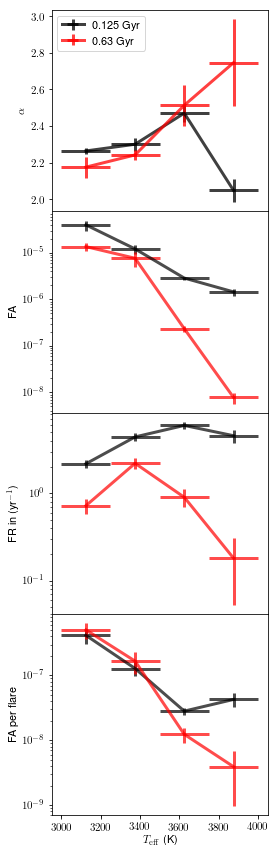

In [142]:

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(4,12),sharex=True)
res = res[res.Tmax != 7000.]
res = res[res.nobin == False]
data = data[data.Tmax != 7000.]
for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin

    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 linewidth=3,
                label='{} Gyr'.format(label),
                 alpha=0.75,color=colorize(label)
           )
    

    
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,legend=False,logy=True,
                 color= colorize(label))
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax4,linewidth=3,alpha=0.7,
                 markersize=100,logy=True,legend=False,
                 color= colorize(label))
           

ax4.set_xlabel(r'$T_\mathrm{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$')

ax2.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax3.set_ylabel(r'FR in (yr$^{-1}$)')
ax4.set_ylabel(r'FA per flare')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')


ax1.legend(loc=2)


plt.xlim(2950,4050)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.)
plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/Paper/alphaFAFR_T2.png', dpi=300)

## Alpha vs Beta

3000.0
3000.0
3250.0
3250.0
3500.0
3500.0
3750.0
3750.0
[ 33.09076691 -33.5947878 ] [1.26800934 2.87834715]


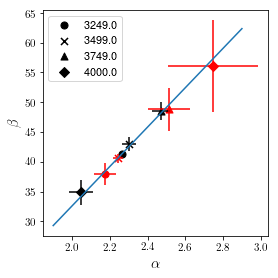

In [221]:

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))
res = res[res.Tmax != 7000]
res = res[res.nobin == False]
for name, f in res.groupby('Tmax'):
    for age, df in f.groupby('age'):
        if age==0.125:
            l=name
        else:
            l=None
        print(df.Tmin[0])
        df.plot(x='alpha', y='beta', xerr='alpha_err', yerr='beta_err',
                kind='scatter',label=l,marker=markers(df.Tmin[0],df.Tmax[0]),
                s=50,color=colorize(df.age[0]),
                ax=ax) 

m,c = linfit(res.alpha,res.beta,res.alpha_err,res.beta_err)

x = np.arange(1.9,3,0.1)
print(m,c)
ax.plot(x,x*m[0]+m[1])
        
        
plt.xlabel(r'$\alpha$',fontsize=15)
plt.ylabel(r'$\beta$',fontsize=15)
plt.tight_layout()
plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/Paper/alpha_vs_beta.png',dpi=300)

## Alpha=2 vs Beta2

/home/eilin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


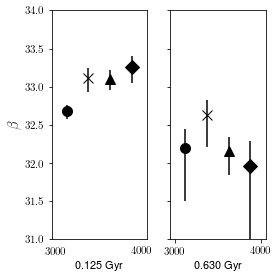

In [224]:

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(4,4),sharey=True)
res = res[res.Tmax != 7000]
res['alpha2'] = 2
r = [.125,.225,.325,.425]
for name, f in res.groupby('Tmax'):
    for age, df in f.groupby('age'):
        if age==0.125:
            l=name
            j=0
        else:
            l=None
            j=1
   
        yerr= np.asarray([df.beta2_low_err.values,df.beta2_high_err.values])
        ax[j].errorbar(name-125, df.beta2.values, yerr=yerr,
                label=l,marker=markers(df.Tmin[0],df.Tmax[0]),
                markersize=10.,color='k',) 
        ax[j].set_xlabel('{:1.3f} Gyr'.format(age))
        ax[j].set_ylim(31,34)
        ax[j].set_xlim(2950,4050)

  
        
ax[0].set_ylabel(r'$\beta$',fontsize=15)
plt.legend(loc=3)
ax[0].tick_params(axis='x', bottom='off') 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0., hspace=None)
plt.tight_layout()
plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/Paper/fixedalpha2_vs_beta.png',dpi=300)

### Plot total energy, total number of flares per cluster

3249.0
3499.0
3749.0
4000.0


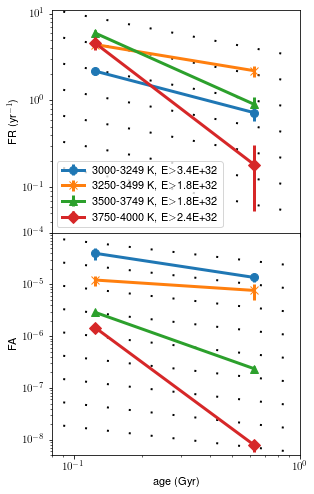

In [220]:
fig, (ax2,ax1) = plt.subplots(nrows=2, ncols=1,figsize=(4.5,7),sharex=True)

time = np.arange(0.09,1,0.01)
skum1 = 0.00000005*np.sqrt(1/time)
skumno1 = 0.0005/time
skum2 = 0.01*np.sqrt(1/time)
skumno = 1/time
data = data[data.Tmax != 7000.]
for label, df in data.groupby(['Tmax','Tmin']):
    df = df.sort_values(by='age')

    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)

    df.plot(x='age',y='FA',yerr='FA_err',
                 kind='line', ax=ax1,linewidth=3,
                 markersize=8,capsize=0,loglog=True,
                  marker=markers(label[1],label[0]),legend=False
               )
    df.plot(x='age',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax2,linewidth=3,
                 markersize=8,capsize=0,loglog=True,
                 label=r'{:.0f}-{:.0f} K, E$>${:.1E}'.format(label[1],label[0],df.threshold.max()),
                 #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                    marker=markers(label[1],label[0]),)
           
    print(label[0])
A = np.power(10,np.arange(-3.2,3,0.45))
B = np.power(10,np.arange(-1.1,3.5,0.3))
for a in A[5:]:
    ax1.plot(time, a*skum1,linewidth=2,linestyle=linestylesdict['loosely dotted'],color='k')#,label=r'$t^{-1/2}$')   
for a in B[6:-3]:    
    ax2.plot(time, a*skum2,linewidth=2,linestyle=linestylesdict['loosely dotted'],color='k') 

ax1.set_xlabel('age (Gyr)')
#ax3.set_xlabel('age (Gyr)')
#ax3.set_ylabel(r'FA per flare')
ax1.set_ylabel(r'FA')# in erg$\cdot$yr$^{-1}$')
ax2.set_ylabel(r'FR (yr$^{-1}$)')

ax2.legend(loc=3,fontsize='medium')

ax2.set_xlim(0.08,1)
ax1.set_ylim(5e-9,1e-4)
ax2.set_ylim(0.03,11)

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.)
plt.savefig('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/Paper/FAFR_age.png',dpi=300)
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFR1e33.png',dpi=300)

# DEPRECATED

## FFD Slopes 

In [ ]:

plt.figure(figsize=(7,6))
pleiades = res[res.age==0.125]
tmin = {3249.:31.9,
        3499.:32.,
        3749.:32.1,
        4000.:32.2,
        7000.:32.1,}
for i, row in pleiades.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='k',linewidth=3,label='{}-{} K'.format(int(row.Tmin),int(row.Tmax)))
m44 = res[res.age==0.63]
tmin = {3249.:31.8,
        3499.:31.9,
        3749.:31.9,
        4000.:32.,
        7000.:31.9,}
for i, row in m44.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='red',linewidth=3,)
plt.legend()#bbox_to_anchor=(0.6,0.27))

plt.xlabel('log( $E_{Kp,flare}$ (erg) )')
plt.ylabel(r'log( frequency in (h$^{-1}$) )')
# ax2.set_xlabel('log(energy in erg)')
# ax2.set_ylabel(r'log(frequency in h$^{-1}$)')
plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/slopes.png',dpi=300)


In [46]:
#Prep FFD results

#Unrestrictive Prep (only merging and shuffling results)
#os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/run_05')
os.chdir('/work1/eilin/data/CLUSTERS_01/Archive_MA_12072018/stars_shortlist_share')
today = time.strftime("%d_%b_%Y", time.gmtime())
run = '05'
locs = [
        ('M44','M44_run_{}_cum_FFD.csv'.format(run),0.630),
        ('Pleiades','Pleiades_run_{}_cum_FFD.csv'.format(run),0.125)]

frames = []
for (key, value,age) in locs:
    df = pd.read_csv(value,
                     usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'maxenerg','n_obj','nflares'],
                     )
    frames.append(df)
res = pd.concat(frames, keys=[x[2] for x in locs])
res = res.reset_index()
res = res.drop('level_1',axis=1)
res = res.rename(index=str, columns={'level_0':'age'})
ages = {4.3:'M67',0.630:'M44',0.125:'Pleiades'}
res['cluster'] = [ages[i] for i in res.age]
res = res.dropna(how='any')
#Transform alpha to conventional value
res.alpha = -res.alpha+1.

#Restrictive Prep (actual changes to the tabled results)

res.Tmax[(res.age==0.12) & (res.Tmin == 3750.)]=4000.
res = res[(res.Tmax-res.Tmin < 500) | (res.Tmax-res.Tmin > 3000)]
res.Tmax[res.Tmax == 3999.] = 4000.
res = res.sort_values(by='Tmax')


res = newres
res

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Tmax,Tmin,alpha,alpha_err,beta,beta_err,cluster,maxenerg,n_obj,nflares,age
0,7000,3000,2.173160,0.026925,40.075363,0.878101,M44,3.104129e+33,740,123,0.630
0,3249,3000,2.200259,0.046217,40.442932,1.508925,M44,2.054954e+33,248,18,0.630
0,3499,3250,1.965258,0.023716,32.844645,0.772636,M44,3.053534e+33,139,41,0.630
0,3749,3500,2.052339,0.051345,35.574942,1.662556,M44,2.183478e+33,140,50,0.630
0,4000,3750,2.129334,0.225961,37.180706,7.300480,M44,4.416213e+32,73,6,0.630
0,7000,3000,2.090804,0.010226,37.879321,0.333392,Pleiades,2.029237e+34,721,423,0.125
0,3249,3000,2.081621,0.013889,36.883376,0.449500,Pleiades,1.126300e+34,307,131,0.125
0,3499,3250,2.166429,0.025145,39.814212,0.817466,Pleiades,8.925924e+33,150,136,0.125
0,3749,3500,2.137608,0.018808,38.831127,0.612787,Pleiades,2.029237e+34,119,111,0.125
0,4000,3750,2.348011,0.073358,45.474374,2.406965,Pleiades,5.258586e+33,52,35,0.125


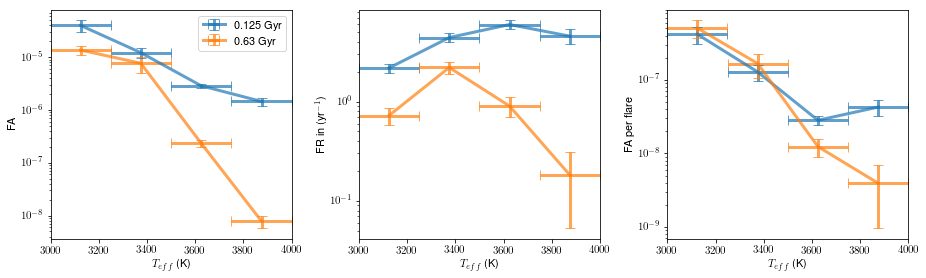

In [209]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(13,4))

data = data[data.Tmax != 7000.]
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax1,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,
                 label='{} Gyr'.format(label))#, color=colors(label[1],label[0]))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,capsize=5,legend=False,logy=True,
                 #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                    #color=colors(label[1],label[0]),
           )
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,legend=False
                 )
           
   # print(label[0])

#ax2.plot(time, skumno,linewidth=2,linestyle='dashed',color='k') 
#ax1.plot(time, skumno1,linewidth=2,linestyle='dashed',color='k') 
ax1.set_xlabel(r'$T_{eff}$ (K)')
ax2.set_xlabel(r'$T_{eff}$ (K)')
ax3.set_xlabel(r'$T_{eff}$ (K)')
ax1.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax2.set_ylabel(r'FR in (yr$^{-1}$)')
ax3.set_ylabel(r'FA per flare')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')
ax1.legend()
plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFRofT.png',dpi=300)

## alpha (age)

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6,64),sharex=True)
for label, df in res.groupby(['Tmax','Tmin']):
  
    print(label[0])
    df.plot(x='age',y='alpha',yerr='alpha_err',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                 label='{}-{} K'.format(int(label[1]),int(label[0])), 
                 linestyle=colors(label[1],label[0]),
                 alpha=0.75,
           )
    
    
ax1.legend(bbox_to_anchor=(0.6,0.27))
ax1.set_xlabel('age (Gyr)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('age (Gyr)')
ax2.set_ylabel(r'$\log\beta$')
plt.xlim(0,0.8)


plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabeta.png',dpi=300)

## Uncertainties on energy etc. from MA_thesis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
#print(os.getcwd())
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist')
Tmin,Tmax=3000.0,7000.0

locs2 = [('Pleiades','share/run_05/clusterenergies_Pleiades_run_05_{}_{}.csv'.format(Tmin,Tmax),0.120,'green'),
         ('M44','share/run_05/clusterenergies_M44_run_05_{}_{}.csv'.format(Tmin,Tmax),0.8,'orange'),
         ('M67','share/run_05/clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.0,'blue')]
for (name, value, age,color) in locs2:
    vars()[name] = pd.read_csv(value,
                     usecols = ['clustered','clusterederr','clusterenergy',
                                'clusterenergy_err','rel_energ_err','Teff',
                                'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',
                                'count_true','energ_true','EPIC'],
                     )
#M67=M67[M67.count_true==1.6]
#M44[M44.Teff > 4000].count()#5170K 3 flares???
#Pleiades[Pleiades.Teff > 4000].sort_values(by='Teff').count()#4620,5170,4410,
#M44.groupby('EPIC').count().shape

In [ ]:

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'jet'
#import matplotlib.pylab as pl
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1,sharey=True,figsize=(10,3),squeeze=True)
for (name, value, age,color) in locs2:
    x = vars()[name]
    if name=='M67': a=20
    else: a=1
    ax1.hist(np.repeat(x.L_bol_err/x.L_bol,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax1.set_xlabel(r'$\sigma _{L_{bol}} / L_{bol}$')
    ax2.hist(np.repeat(x.clusterederr/x.clustered,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax2.set_xlabel(r'$\sigma _{ED} / ED$')
    ax3.hist(np.repeat(x.rel_energ_err,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax3.set_xlabel(r'$\sigma _{E_{Kp,flare}} /E_{Kp,flare}$')
plt.ylim(.1,350)
plt.xlim(0,2)

plt.legend(bbox_to_anchor=(0.85,0.80))
fig.tight_layout(pad=0)
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/relerr.png',dpi=300)

In [ ]:
for (name, value, age) in locs2:
    x = vars()[name]
    x = x[x.count_true < 5.]
    print(r'{:8} mean relative error on ED         is {:.2f}$\pm${:.2f}.'.format(name, (x.clusterederr/x.clustered).mean(),(x.clusterederr/x.clustered).std()))
    print(r'{:8} mean relative error on energy     is {:.2f}$\pm${:.2f}.'.format(name, (x.rel_energ_err).mean(),(x.rel_energ_err).std()))
    print(r'{:8} mean relative error on luminosity is {:.2f}$\pm${:.2f}.'.format(name, (x.L_bol_err/x.L_bol).mean(),(x.L_bol_err/x.L_bol).std()))

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,7),sharex=True)
res = res[res.Tmax != 7000]

for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df.plot(x='midTbin',y='beta',yerr='beta_err',xerr='Terr',
      kind='line', ax=ax2,legend=False,
                 markersize=10,linewidth=5,marker='o',alpha=0.75,
            label='{} Gyr'.format(label),
                       )
    
    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                label='{} Gyr'.format(label),
                 alpha=0.75,
           )
ax1.legend(bbox_to_anchor=(0.55,0.15))

ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('$T_{eff}$ in (K)')
ax2.set_ylabel(r'$\log\beta$')

plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabetaofT.png',dpi=300)
#.format(today)